In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../src')  

import meneame as mn
import s4_figures_paper as s4

import pandas as pd

import networkx as nx
import numpy as np
import pylab as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import textalloc as ta

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [2]:
# Set up paths and topics to study
# Read folder paths from the file
with open('../dirs.txt', 'r') as f:
    lines = [line.strip() for line in f]

path = lines[0]

# Define the data path
path_data = path + 'data_snapshot/'
path_save_embeddings = "../data/embeddings/"
path_figures = lines[1]

## 1. **Data Preparation**:

Reads comments data, ideology from external sources (Twitter and Political )


In [3]:
## Read idelogoy from pollitical watch
df = pd.read_csv("../ideology_twitter/media_ideology_politicalwatch/media_general_topics/Filtered_Sources.csv")
df = df[["domain", "bias"]]
df["domain"] = df["domain"].str.split(".").str[1]
ideology_media_watch = df.set_index("domain").to_dict()["bias"]

In [4]:
## Read users-story data
data_st = mn.read_comments_topics(path_data, bipartite=True)#, min_time="2022-12-01", max_time="2023-08-01")
data_st = data_st.loc[(data_st["story_vote_time"] >= "2022-12-01") &
                      (data_st["story_vote_time"] <= "2023-08-01")]

print(data_st.agg({"story_id": ["count", "nunique"], "username_vote": "nunique"}))

# # Read user-user data, merged with topics
data_com = mn.read_comments_topics(path_data)
#data_com = data_com.loc[data_com["story_id"].isin(set(data_st["story_id"]))]
data_com = data_com.loc[(data_com["comment_vote_time"] >= "2022-12-01") &
                      (data_com["comment_vote_time"] <= "2023-08-01")]


Data time range 2022-11-26 23:04:00, 2023-08-08 19:55:00
         story_id  username_vote
count     1869190            NaN
nunique     47887        11156.0
Data time range 2022-11-14 11:42:20, 2023-08-09 12:46:05


In [5]:

## Descriptive statistis of the user-story data
data_stats = (data_st
           .groupby("final_topic")
           .agg({"story_id": ["nunique", "count"],
                 "story_vote": [lambda x: np.sum(x > 0), lambda x: np.sum(x < 0)]})
           .sort_values(by=("story_id", "nunique"), ascending=False)
           .reset_index()
)
data_stats.columns = ["Topic", "Number stories", "Number votes:", "Number upvotes", "Number downvotes"]

data_stats = data_stats.applymap(
    lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) else x
)

# Save to latex, add comma to numbers and a descriptive captions
print(data_stats.to_latex(index=False, caption="Statistics of the stories in the dataset", label="tab:data_stats",
                    column_format="lcccc")
)



\begin{table}
\caption{Statistics of the stories in the dataset}
\label{tab:data_stats}
\begin{tabular}{lcccc}
\toprule
Topic & Number stories & Number votes: & Number upvotes & Number downvotes \\
\midrule
Politics & 7,427 & 411,591 & 378,528 & 33,063 \\
Russia & 2,394 & 77,828 & 64,240 & 13,588 \\
Public services & 1,621 & 85,154 & 81,637 & 3,517 \\
Crime & 1,537 & 73,465 & 69,074 & 4,391 \\
Climate & 1,458 & 41,847 & 39,661 & 2,186 \\
Crypto/net & 814 & 26,533 & 24,414 & 2,119 \\
Inflation & 763 & 26,724 & 25,316 & 1,408 \\
3 & 176 & 4,038 & 3,740 & 298 \\
17 & 13 & 351 & 348 & 3 \\
2 & 11 & 296 & 281 & 15 \\
10 & 9 & 289 & 281 & 8 \\
5 & 7 & 404 & 379 & 25 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2111071466.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_stats = data_stats.applymap(


In [6]:
# Keep domains to filter later on
domains = set(data_st["story_original_url_domain"].unique())
domains_users = set(data_com["username_post"].unique()) | set(data_com["username_vote"].unique())

# Create a dictionary to color the nodes according to the average vote 
# +1 = always postiive, -1 = always negative. For comments cutoff at 0 since there are few negative votes
nodes_st_color = data_st.groupby("username_vote")["story_vote"].mean()

nodes_com_color = data_com.groupby("username_vote")["comment_vote"].mean()
nodes_com_color[nodes_com_color<0] = 0
nodes_color = nodes_com_color.to_dict()

In [7]:
# For outlets, use paths
which_bipartite = "_all_no_only_positive"
path_emb_sheep_outlets = f"../data/embeddings/embeddings_pca_sheep_bipartite_normed_False_min_votes_10{which_bipartite}.csv"
path_emb_ca_outlets    = f"../data/embeddings/embeddings_pca_ca_bipartite_min_votes_10{which_bipartite}.csv"

# Read data
df_emb_sheep_outlets = s4.read_data(path_emb_sheep_outlets, mn.domain_ideology_twitter, ideology_media_watch)
df_emb_ca_outlets = s4.read_data(path_emb_ca_outlets, mn.domain_ideology_twitter, ideology_media_watch)


# For comments, use paths
which_unipartite = "_all"
path_emb_sheep_outlets = f"../data/embeddings/embeddings_pca_sheep_unipartite_normed_True_no_outliers_min_votes_10{which_unipartite}.csv"
path_emb_ca_outlets    = f"../data/embeddings/embeddings_pca_ca_unipartite_no_outliers_min_votes_10{which_unipartite}.csv"

# Read data
df_emb_sheep_comments = s4.read_data(path_emb_sheep_outlets, mn.domain_ideology_twitter, ideology_media_watch)
df_emb_ca_comments = s4.read_data(path_emb_ca_outlets, mn.domain_ideology_twitter, ideology_media_watch)

/Users/Cande007/anaconda3/envs/polarization/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/Cande007/anaconda3/envs/polarization/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/Cande007/anaconda3/envs/polarization/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/Cande007/anaconda3/envs/polarization/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/Cande007/anaconda3/envs/polarization/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
 

## Figure correlation of outlets (Fig. 1)

Scatter plot of the correlation between the embeddings at the outlet level for Russia and Politics

Subgraphs with the correlation with external sources


SignificanceResult(statistic=-0.9296187683284455, pvalue=1.525010311471177e-14)
0.9296187683284457 0.5808751435569703
SignificanceResult(statistic=0.8048509643483344, pvalue=1.572121974009717e-14)


/Users/Cande007/anaconda3/envs/polarization/lib/python3.11/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))
/Users/Cande007/anaconda3/envs/polarization/lib/python3.11/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))


0.8048509643483343 0.7588820839053646


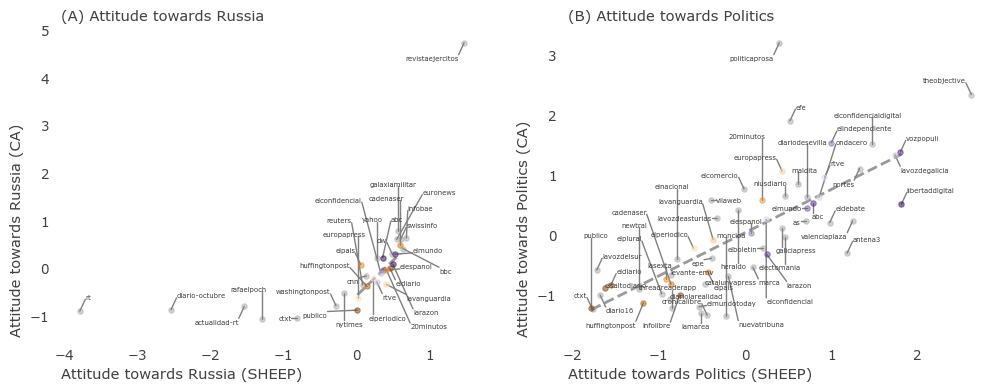

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
s4.plot_two_dim(df_emb_sheep_outlets, df_emb_ca_outlets, flip=[0], domains=domains, 
             top="Russia", suffix1="_pca_1d", suffix2="_0", 
             columns=["Attitude towards Russia (SHEEP)", "Attitude towards Russia (CA)"], d_color=mn.domain_ideology_twitter)
plt.title("(A) Attitude towards Russia")

plt.subplot(1, 2, 2)
# plt.ylim(-1, 1)
s4.plot_two_dim(df_emb_sheep_outlets, df_emb_ca_outlets, flip=None, domains=domains, 
             top="Politics", suffix1="_pca_1d", suffix2="_1", 
             columns=["Attitude towards Politics (SHEEP)", "Attitude towards Politics (CA)"], d_color=mn.domain_ideology_twitter)
plt.title("(B) Attitude towards Politics")

plt.savefig("../figures/fig1_attitudes_outlets.pdf", bbox_inches="tight")

### Subplots (correlation with Twitter)

In [ ]:
s4.create_subplots_external_ideology(df_emb_sheep_outlets, df_emb_ca_outlets, top="Politics", var_sheep="_pca_1d", var_ca="_1", flip=[False, False], save=False)
s4.create_subplots_external_ideology(df_emb_sheep_outlets, df_emb_ca_outlets, top="Russia", var_sheep="_pca_1d", var_ca="_0", flip=[True, False], save=False)

## Figure network with positive/negative edges

Network created
4548 105414
{'000a937e1a3eefa91205084b452b625cc25ccce0': array([-0.03283338, -0.00279449]), '01ca6288e65faee81ed55d92a67e8d9c41e74bff': array([-0.01750156, -0.00190026]), '41d2e03a8d082a5aff9d3122f2962f322c951935': array([-0.0124234 , -0.00137511]), 'dc0b1092d511f2efc16bf526a5cc8ec8d45ac44a': array([-0.02392603, -0.00537208]), 'f4a59121b5f0c278bda353a87e5d5c23135406f7': array([-0.03717942,  0.01768592]), '000b2b9c728a45b39d4fe302df79f591206d2247': array([-0.01648694, -0.0024328 ]), '07a802e1d3f099edfbe51f862e95124fc607747a': array([-0.02625423, -0.01419123]), '0e4203bdf2cd346314f4dfd2ecb3e40c4a0549f7': array([-0.02251911,  0.00346572]), '1eeb45cd68a3029dd3f90969a8ed5a4645daf8dc': array([-0.01880652, -0.00262272]), '469e11eb226e16925db69cdcc9a09f4a3d715d99': array([-0.0051539 , -0.00378665]), '49e1b186241bb9491e3ab402aa41a58966dd0f67': array([-0.01111384, -0.00412541]), '4b7b3ce9d9772dae74309a24d458995d36c751ba': array([-0.01359444, -0.00243555]), '65411d8fc892016453b901

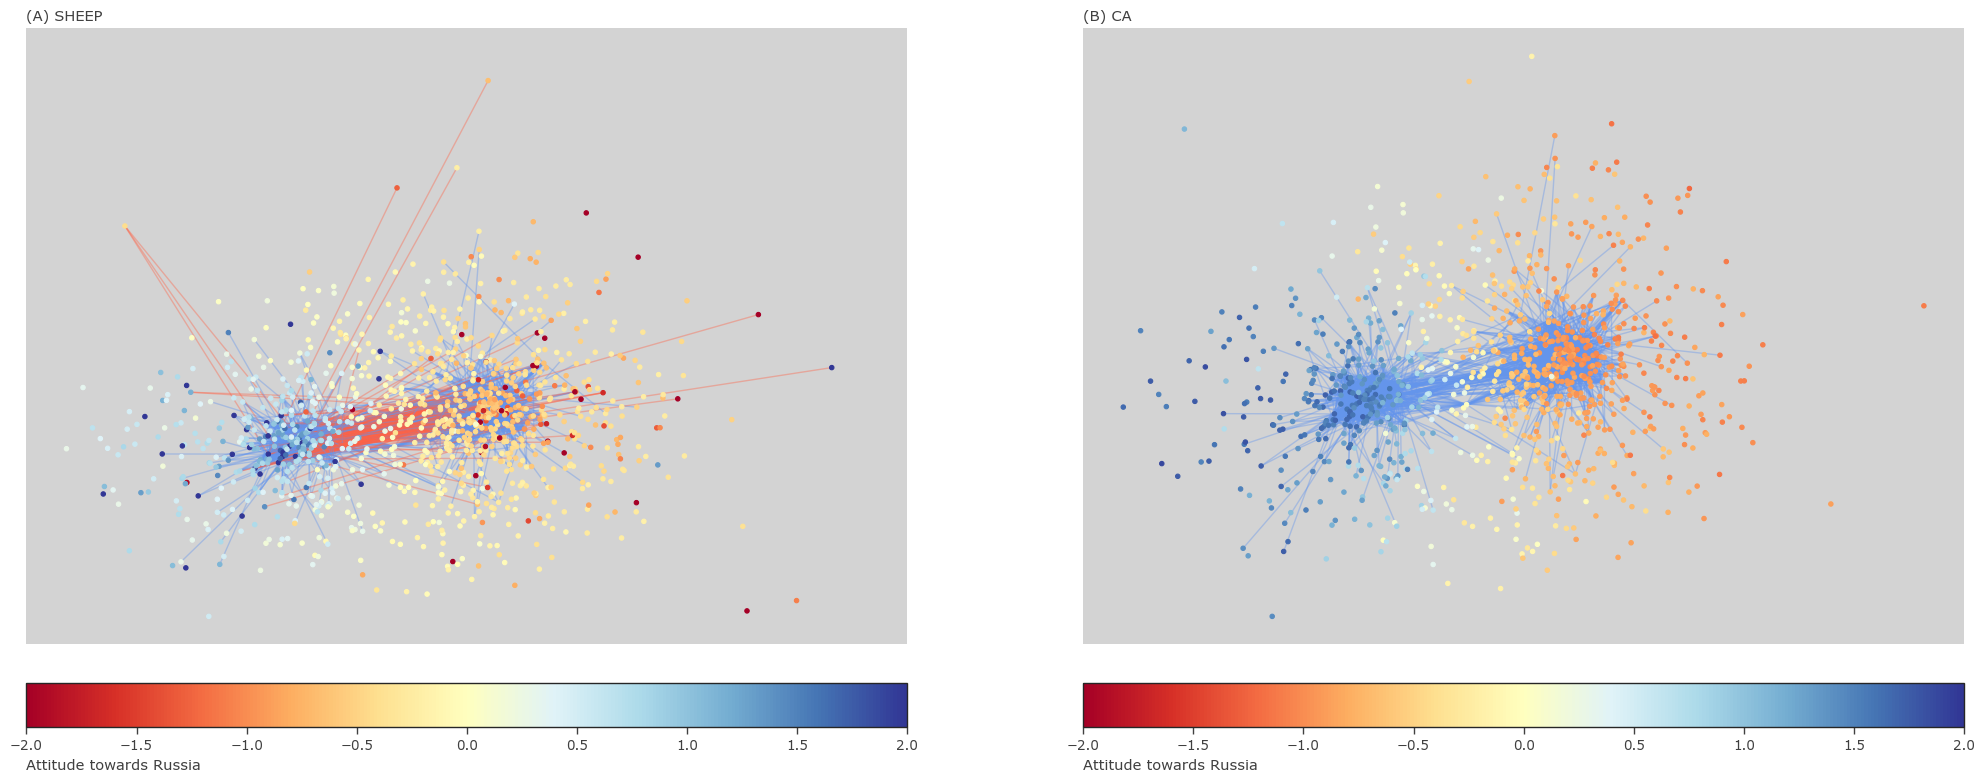

Network created
7332 405130
{'0002bf5ecd06a6a7d22565f80abe99538a99d5f2': array([ 0.01313134, -0.01445809]), '1d734d123562c35186980a6ad4da26374d22041c': array([ 0.01069013, -0.00702001]), '443e7cac8bd0b9737b02eeb305ac06c31e784fb8': array([-0.03500782, -0.05702637]), '8f3d87919c8ed0292bedba976238b0c7d530c50e': array([-0.00013815,  0.00634678]), '9b408255b3c5e76f0cfa5939c7f2aa7253fd39a9': array([ 0.02623377, -0.00408228]), 'a30513fe92479ab255ed772aa6f3607c0a9ac9ea': array([ 0.07824212, -0.02223214]), 'b110cc54f01d566507f26c33af51d8e557e1fe25': array([ 0.00892167, -0.00498016]), 'c583b0e317ca8d0c965b29db1faa1516a1387d08': array([ 0.01390602, -0.01178994]), 'f3610fff3c2331412e76d1eb9b5c7a8db2f101b6': array([ 0.01005489, -0.00554727]), 'fcfd53721273413c154da790379a0bb2b8052b1c': array([-0.00615441, -0.0007565 ]), '000a937e1a3eefa91205084b452b625cc25ccce0': array([ 0.01300488, -0.00985489]), '0278bba4f150a27baa03818bd98dba13a4d4c93f': array([ 0.0057238 , -0.00076603]), '08a9736e161a301519867d

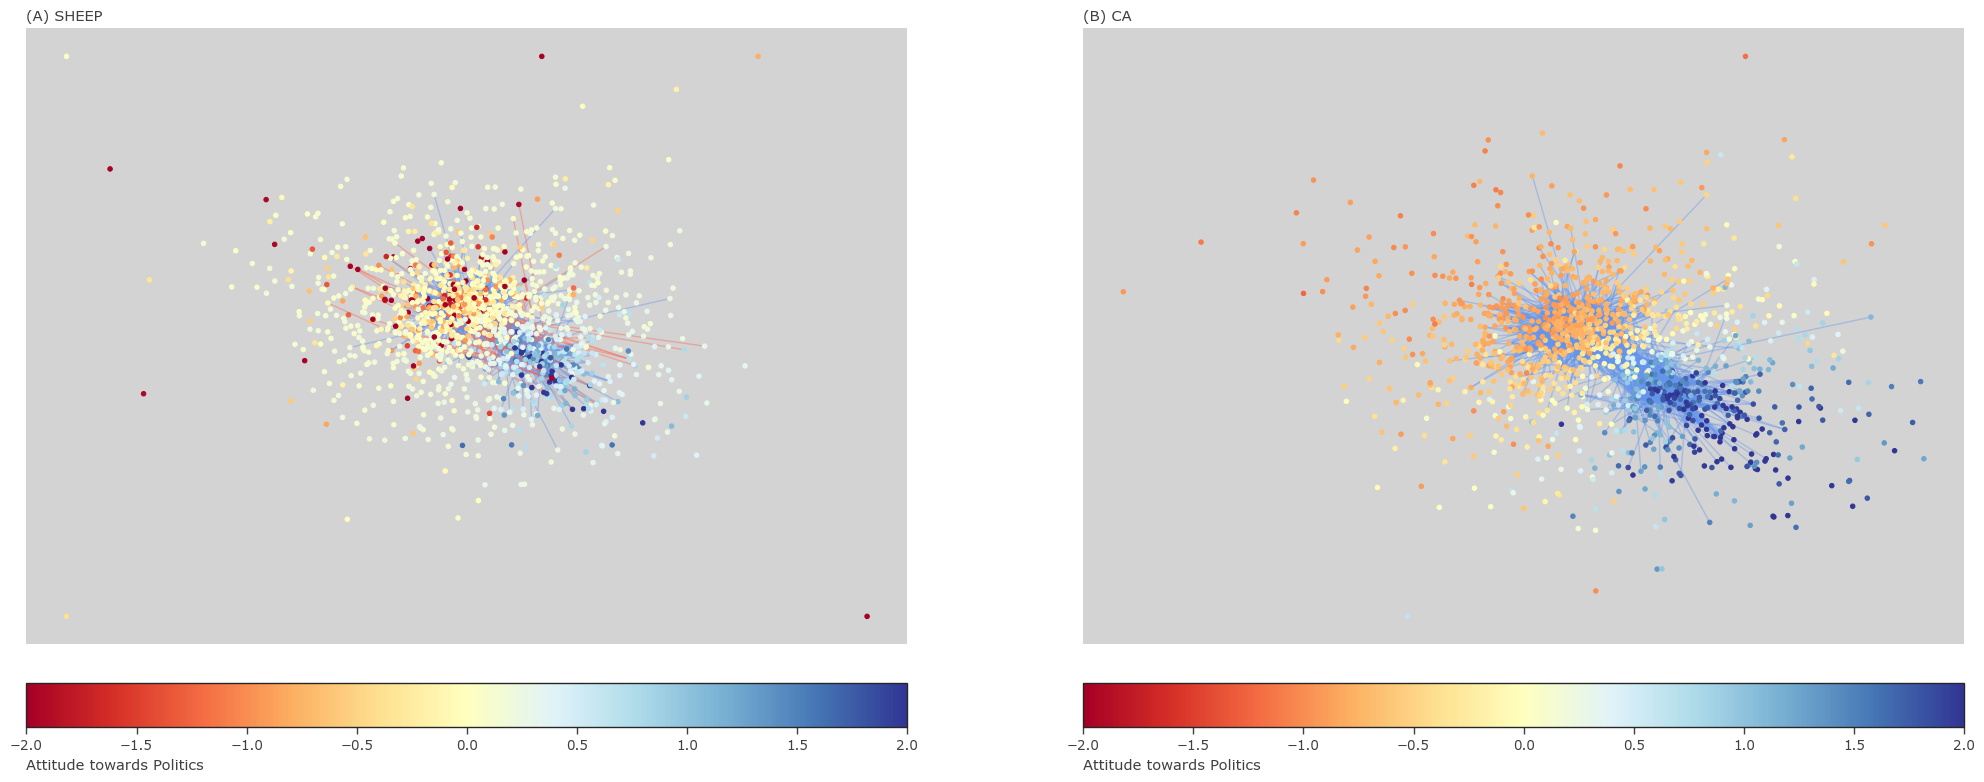

In [10]:
for topic in ["Russia", "Politics"]:

    if topic == "Russia":
        threshold = 3
    else:
        threshold = 3

    # Get number of votes between users
    com_network = (data_com
                .loc[data_com["final_topic"] == topic, :]
                .loc[:, ["comment_vote", "username_post", "username_vote"]]
                .groupby(["username_post", "username_vote"])
                .agg({"comment_vote": "sum"})
                .reset_index()
    )


    # Create network usingn networkx
    G = nx.Graph()
    for i, row in com_network.iterrows():
        G.add_edge(row["username_post"], row["username_vote"], 
                   weight_full = row["comment_vote"],
                   weight=row["comment_vote"] if row["comment_vote"]>0 else 0, color="tomato" if row["comment_vote"] < 0 else "cornflowerblue")
    print("Network created")
    print(G.number_of_nodes(), G.number_of_edges())

    # Create positioning
    pos2 = nx.spring_layout(G, seed=2)
    print(pos2)

    # Keep only a sample of 3000 nodes in the network
    nodes = list(G.nodes)
    np.random.seed(0)
    np.random.shuffle(nodes)
    # Filter out some without embedding
    d = df_emb_sheep_comments.set_index("story")[f"{topic}_pca_1d"].to_dict() 
    nodelist = [node for node in G.nodes if (d.get(node) is not None) and (np.isfinite(d[node]))]  
    # Keep 3000
    nx.write_gml(G, f"../data/network_{topic}.gml")
    nodes = nodes[:3000]
    G = G.subgraph(nodes)
    nx.write_gml(G, f"../data/network_{topic}_subset.gml")
    print(G.number_of_nodes(), G.number_of_edges())
    pos2 = {k: v for k, v in pos2.items() if k in G.nodes}

    # Put ouliers at 2 STD from the center of the network
    df_pos = pd.DataFrame(pos2).T
    df_pos.columns = ["x", "y"]
    for var in ["x", "y"]:
        df_pos[var] = (df_pos[var] - np.mean(df_pos[var])) / np.std(df_pos[var])
        # Put outliers at 2 STD, not including the outliers
        std_no_out = np.std(df_pos.loc[df_pos[var].abs() < 2, var])
        mean = np.mean(df_pos.loc[df_pos[var].abs() < 2, var])
        th = 2*std_no_out
        print(th)
        df_pos.loc[df_pos[var] > th, var] = th
        df_pos.loc[df_pos[var] < -th, var] = -th
    pos = df_pos.to_dict(orient="index")
    pos = {k: [v["x"], v["y"]] for k, v in pos.items()}

    # Plot networks
    fig = plt.figure(figsize=(25, 10))
    ax = fig.add_subplot(121)
    # Add a gray background to see the yellow points
    ax.set_facecolor("lightgray")
    s4.plot_network(G, pos, df_emb_sheep_comments, f"{topic}_pca_1d", ax, threshold=threshold)
    plt.title("(A) SHEEP")
    #plt.grid(True)
    #ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    ax = fig.add_subplot(122)
    ax.set_facecolor("lightgray")
    s4.plot_network(G, pos, df_emb_ca_comments, f"{topic}_0", ax, norm_color=False, threshold=threshold)
    plt.title("(B) CA")
    #plt.grid(True)
    #ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    
    plt.savefig(path_figures + f"fig_{topic}_network_comments.pdf", bbox_inches="tight")
    plt.show()


In [11]:
df_pos.sort_values(by="x").head(1000)

x         y
ffeca0ba695193f529aeb0bfb0093200c65fcf9c -0.485801  0.160727
2d5fce3d5e63c8aa144ab8aeb6b4bf4b62c015b8 -0.485801  0.115680
ca064d7e4b34dc1b7db76370b19ac39609b58e87 -0.485801 -0.264945
9c7737bad3717956ad8905abc8f3943f767d4c61 -0.485801  0.465000
c7c6a805c643622a8087e4c122b69463e7949e09 -0.485801  0.208076
...                                            ...       ...
e14053afebe276776b5a6aecf8e6f93cfecbc51c -0.045317 -0.115329
0d48b0ec579765fb7e2d5f861baf200a84d957b6 -0.045246  0.075575
4d3198874bd2b875eba89e19ab5e77e945c43902 -0.045115 -0.059330
3fbe4fdc0fe205578fd80de744944ca40b644dea -0.045067  0.146043
71f3ff5a483dc16b96aa2bebec9ee0acb79b417c -0.044958  0.038882

[1000 rows x 2 columns]

In [12]:
## Print example comments for the paper
russia_comments = data_com.loc[data_com["final_topic"] == "Russia", ["username_post", "comment_id"]]
russia_comments = pd.merge(russia_comments,
          pd.read_csv(path_data+'df_comments_urls.tsv.gz', sep="\t", compression="gzip", usecols=["comment_id", "comment_text"])

)

pol_comments = data_com.loc[data_com["final_topic"] == "Politics", ["username_post", "comment_id"]]
pol_comments = pd.merge(pol_comments,
          pd.read_csv(path_data+'df_comments_urls.tsv.gz', sep="\t", compression="gzip", usecols=["comment_id", "comment_text"])

)


def print_top_comments(df, df_emb, var):
    # Add ideology (sheep)
    r = pd.merge(df,
                df_emb[["story", var]],
                left_on="username_post",
                right_on="story").dropna()

    r = r.sort_values(by=var).drop_duplicates(subset="username_post", keep="first")
    print(r.head(n=10)["comment_text"].values)
    print(r.tail(n=10)["comment_text"].values)


print_top_comments(russia_comments, df_emb_ca_comments, "Russia_0")
print_top_comments(pol_comments, df_emb_ca_comments, "Politics_0")

print_top_comments(russia_comments, df_emb_sheep_comments, "Russia_pca_1d")
print_top_comments(russia_comments, df_emb_ca_comments, "Russia_0")



['#5 "Links shared on Twitter, including links shared in Direct Messages, will automatically be processed and shortened to an http://t.co link.". help.twitter.com/en/using-twitter/url-shortener'
 '#30 oye, pues te votan positivo reconocidos fascistas de Facheame.. . En fin, la equidistontancia OTANISTA'
 '#3 que si  Manolito, que ya sabemos que en una guerra entre nazis y comunistas tu te poscionarias en favor de los Nazis, no hace falta que sigas haciendo el ridículo.'
 'hahaha nunha semana ou dúas está as portas de Karkhov. Maskirovka de libro.'
 '#12 Dejará de salirles rentable cuando los de abajo los matemos.'
 'Europa tiene el síndrome de la mujer maltratada. E irá a peor, ni siquiera hemos llegado a la fase de negación.'
 'Bueno, no me parece raro viniendo de Rusia, ya tiene una larga trayectoria de este tipo de trato a sus tropas, nada nuevo bajo el sol.'
 'Voto SPAM, no por el meneante, sino por el panfleto. Unas pechugas de pollo a la plancha con ensalada de tomate y un yogur.

## Figure 2 and 3

### 2/3.1 Compare SHEEP and CA

Scatter plot SHEEP vs CA embedding

In [13]:
# Check if the dimension needs to be flipped by looking at the votes of the users to outlets
if 0:
    for i, df_emb in enumerate([df_emb_sheep_comments, df_emb_ca_comments]):
        for topic in ["Russia", "Politics"]:
            raw_right = df_emb.loc[df_emb[f"{topic}{['_pca_1d','_0'][i]}"]>1, "story"]
            d = (data_st
                 .loc[(data_st["final_topic"] == topic) & (data_st["username_vote"].isin(set(raw_right)))]
                 .groupby("story_original_url_domain")["story_vote"]
                 .agg([np.mean, len])
            )
            d = d.loc[d["len"]>50]
            d = d.sort_values("mean", ascending=False)
            display(pd.concat([d.head(), d.tail()]))
            

#sheep russia = ok
#sheep politics = ok
#ca russia = ok
#ca politics = ok

In [14]:
# Helper functions

def create_left_right(data_st, topic="Politics", left=["ctxt", "cronicalibre"], right=["theobjetive", "vozpopuli"]):
    # Create a dict for the username_vote in data_st, -1 if they vote positive to ctxt, +1 if thety vote positive to theobjective or vozpopuli
    d = data_st.loc[data_st["final_topic"]==topic]
    d["media"] = d["story_original_url_domain"].apply(lambda x: "left" if x in left else ("right" if x in right else "center"))
    d = d.groupby(["username_vote", "media"])["story_vote"].agg(["mean", len])
    # Pivot
    d = d.unstack()
    left = d.loc[(d[("len", "left")] > 5) & (d[("mean", "left")] > 0.9) & (d[("mean", "right")] < 0.5)].index
    right = d.loc[(d[("len", "right")] > 5) & (d[("mean", "right")] > 0.9) & (d[("mean", "left")] < 0.5)].index
    return set(left), set(right)

# plot the right and left
def plot_outliers(d, left_r, right_r):
    # Make a scatter plot with empty circles (just outside edges)
    left_r = list(left_r & set(d.index))
    right_r = list(right_r & set(d.index))
    plt.scatter(d.loc[left_r, d.columns[0]], d.loc[left_r, d.columns[1]], 
                c="none", edgecolors="red", s=30, zorder=9)
    plt.scatter(d.loc[right_r, d.columns[0]], d.loc[right_r, d.columns[1]],
                c="none", edgecolors="blue", s=30, zorder=9)
    
    
left, right = create_left_right(data_st, topic="Politics", left=["ctxt", "cronicalibre"], right=["theobjetive", "vozpopuli"])
left_r, right_r = create_left_right(data_st, topic="Russia", left=["rt", "actualidad-rt"], right=["revistaejercitos"])

SignificanceResult(statistic=0.7888183470688804, pvalue=0.0)
0.7888183470688805 0.5613048957455069


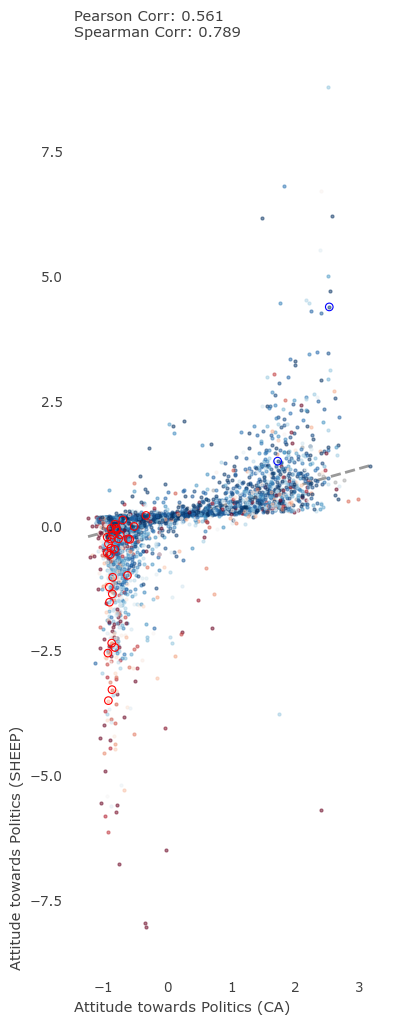

In [15]:
plt.figure(figsize=(4,12))
d = s4.plot_two_dim(df_emb_ca_comments, df_emb_sheep_comments, flip=None, domains=domains_users, 
             top="Politics", suffix1="_0", suffix2="_pca_1d", 
             columns=["Attitude towards Politics (CA)", "Attitude towards Politics (SHEEP)"], 
             d_color=nodes_com_color, annotate=False, show_regression="lowess", s=5, alpha=0.5,
             cmap=plt.cm.RdBu)
# Plot people that focus on RT media!
plot_outliers(d, left, right)
plt.savefig("../figures/fig2_Politics_scatter_ca_vs_sheep.pdf", bbox_inches="tight")


SignificanceResult(statistic=0.8800848278060222, pvalue=0.0)
0.8800848278060223 0.682090335639261


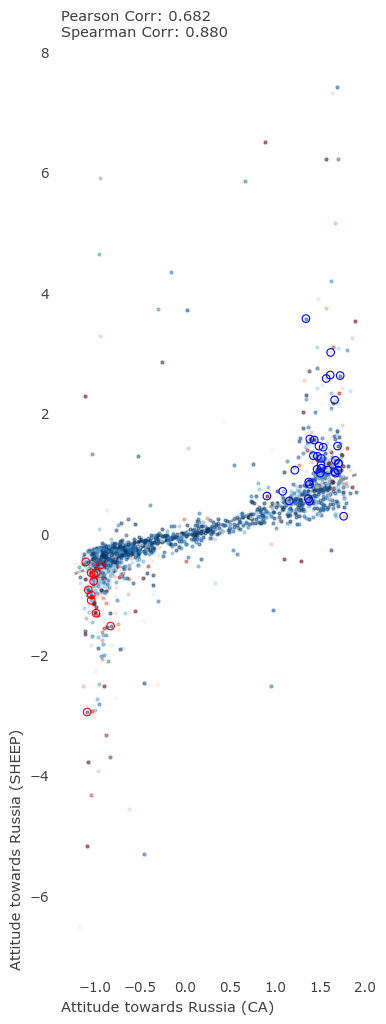

In [16]:
plt.figure(figsize=(4,12))
d = s4.plot_two_dim(df_emb_ca_comments, df_emb_sheep_comments, flip=None, domains=domains_users, 
             top="Russia", suffix1="_0", suffix2="_pca_1d", 
             columns=["Attitude towards Russia (CA)", "Attitude towards Russia (SHEEP)"], 
             d_color=nodes_com_color, annotate=False, show_regression="lowess", s=5, alpha=0.5,
             cmap=plt.cm.RdBu)
# Plot people that focus on RT media!
plot_outliers(d, left_r, right_r)
plt.savefig("../figures/fig2_Russia_scatter_ca_vs_sheep.pdf", bbox_inches="tight")


### Heatmaps

In [17]:
# Get dictionaries
d_partitions = dict()
for top in ["Russia", "Politics"]:
    As1  = s4.plot_vote_matrix(data_com, f"{top}", df_emb_sheep_comments, 
                    var="_pca_1d", flip=False, bins=None, type="len", label="SHEEP", plot=False)
    Ac1 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_ca_comments, 
                    var="_0", flip=False, bins=None, type="len", label="CA", plot=False)
    As2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_sheep_comments, 
                    var="_pca_1d", flip=False, bins=None, type="sum_vote", label="SHEEP", plot=False)
    Ac2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_ca_comments, 
                    var="_0", flip=False, bins=None, type="sum_vote", label="CA", plot=False)
    print(top, "sheep")
    d_partitions[f"{top}_sheep"] = s4.find_partitions(As1, As2)
    print(top, "ca")
    d_partitions[f"{top}_ca"] = s4.find_partitions(Ac1, Ac2)

# Create squares
d_squares = dict()
for key, d_part in d_partitions.items():
    d_squares[key] = s4.get_squares(d_part)

d_squares

Russia sheep
Russia ca
Politics sheep
Politics ca


{'Russia_sheep':     min   max
 0            
 0 -0.97 -0.50
 1 -0.35  0.34
 2  0.73  1.28,
 'Russia_ca':     min   max
 0            
 0 -1.02 -0.82
 1 -0.65  0.25
 2  1.21  1.62,
 'Politics_sheep':     min   max
 0            
 0 -1.80 -0.54
 1 -0.13  0.13
 2  0.17  0.27
 3  0.44  1.22,
 'Politics_ca':     min   max
 0            
 0 -0.94 -0.70
 1 -0.60  0.03
 2  0.67  1.22
 3  1.77  2.01}

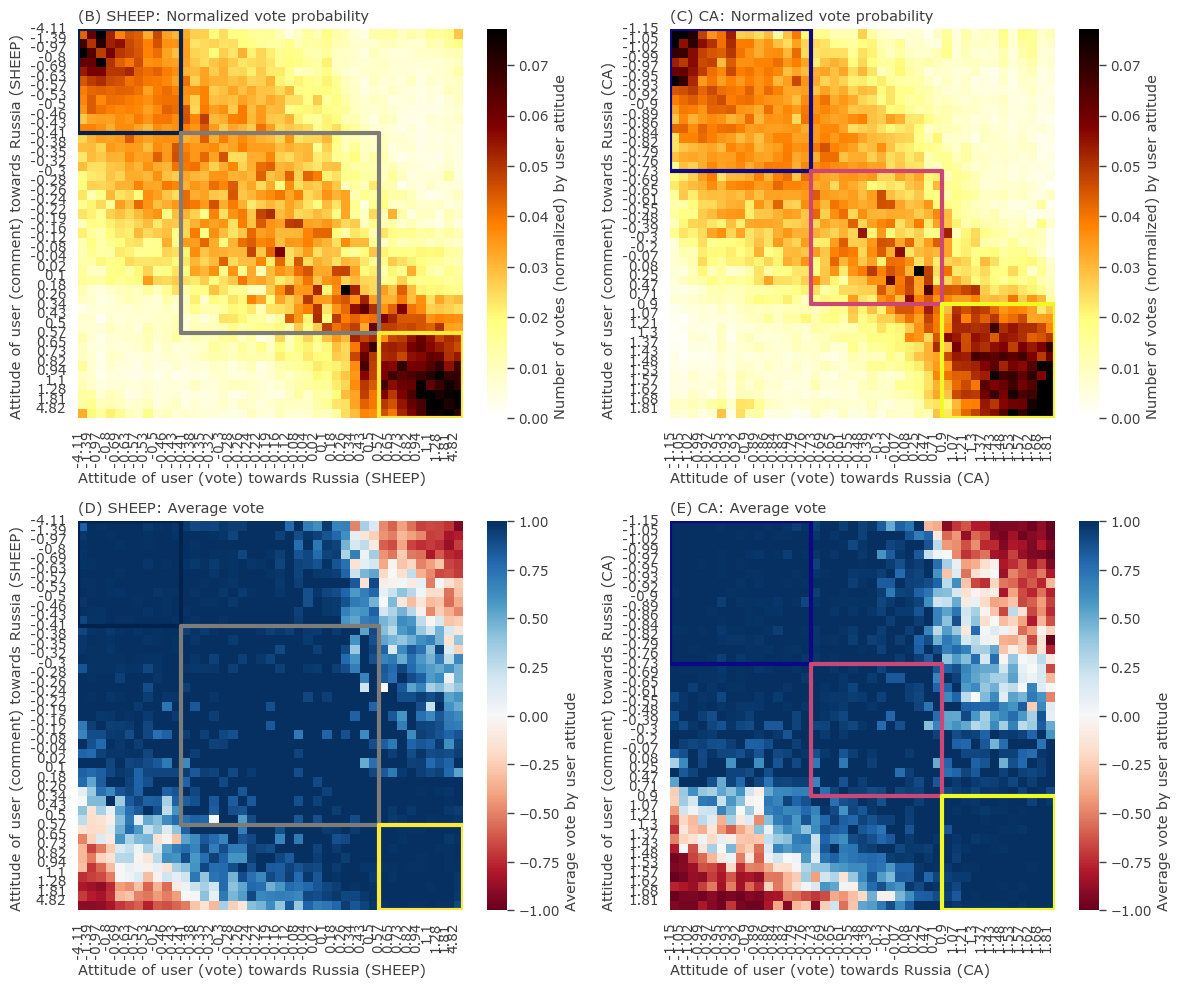

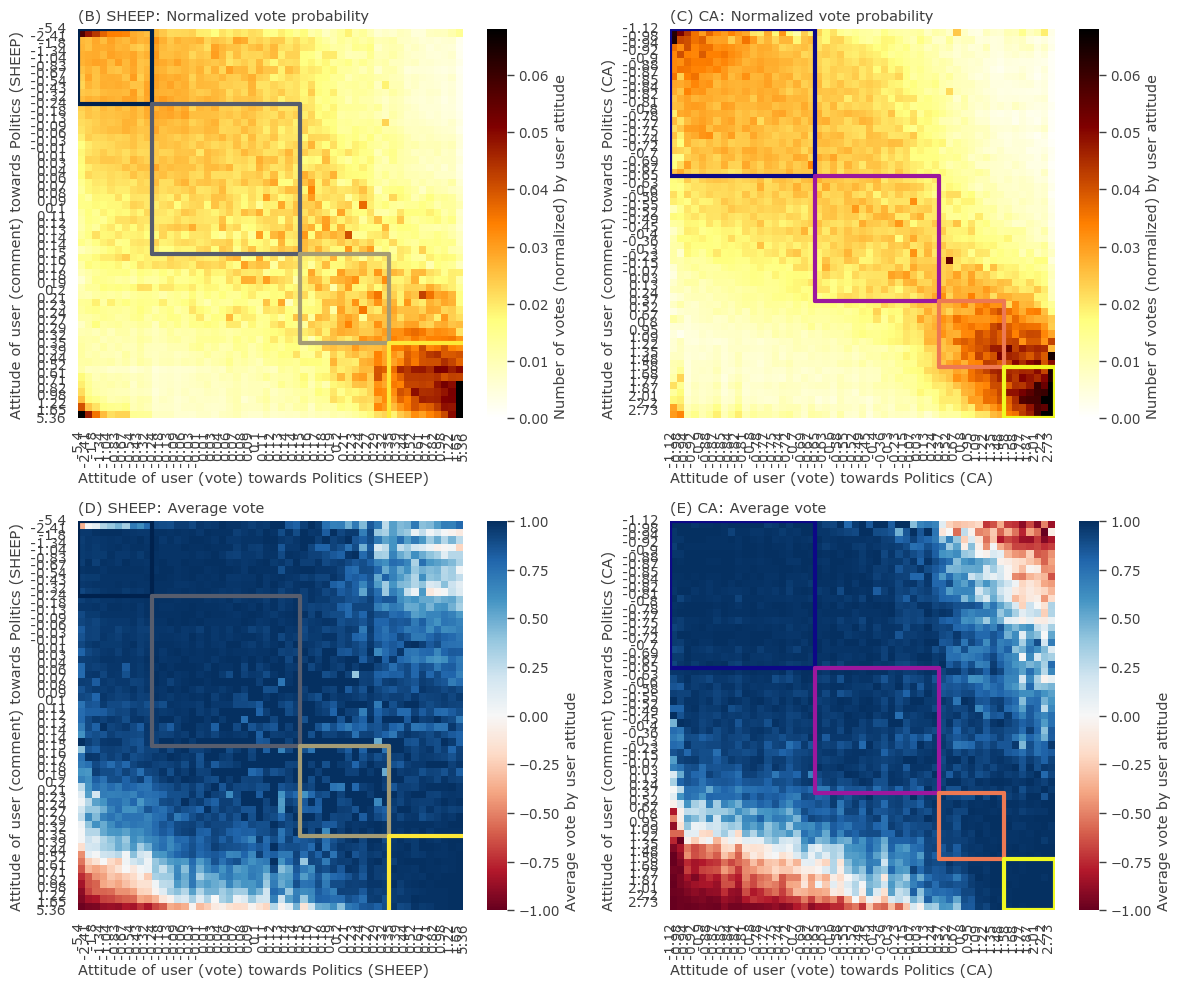

In [18]:

for top in ["Russia", "Politics"]:
    # TODO Robustness: weight by sum_user
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    As1  = s4.plot_vote_matrix(data_com, f"{top}", df_emb_sheep_comments, 
                    var="_pca_1d", flip=False, bins=None, type="len", label="SHEEP", squares=d_squares[f"{top}_sheep"])
    
    plt.title("(B) SHEEP: Normalized vote probability")

    plt.subplot(2, 2, 2)
    Ac1 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_ca_comments, 
                    var="_0", flip=False, bins=None, type="len", label="CA", squares=d_squares[f"{top}_ca"])
    
    plt.title("(C) CA: Normalized vote probability")

    plt.subplot(2, 2, 3)
    As2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_sheep_comments, 
                    var="_pca_1d", flip=False, bins=None, type="sum_vote", label="SHEEP", squares=d_squares[f"{top}_sheep"])
    plt.title("(D) SHEEP: Average vote")

    plt.subplot(2, 2, 4)
    Ac2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_ca_comments, 
                    var="_0", flip=False, bins=None, type="sum_vote", label="CA", squares=d_squares[f"{top}_ca"])
    plt.title("(E) CA: Average vote")
    plt.tight_layout()
    plt.savefig(f"../figures/fig2_{top}_vote_matrix.pdf", bbox_inches="tight")
    plt.savefig(f"../figures/fig2_{top}_vote_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()


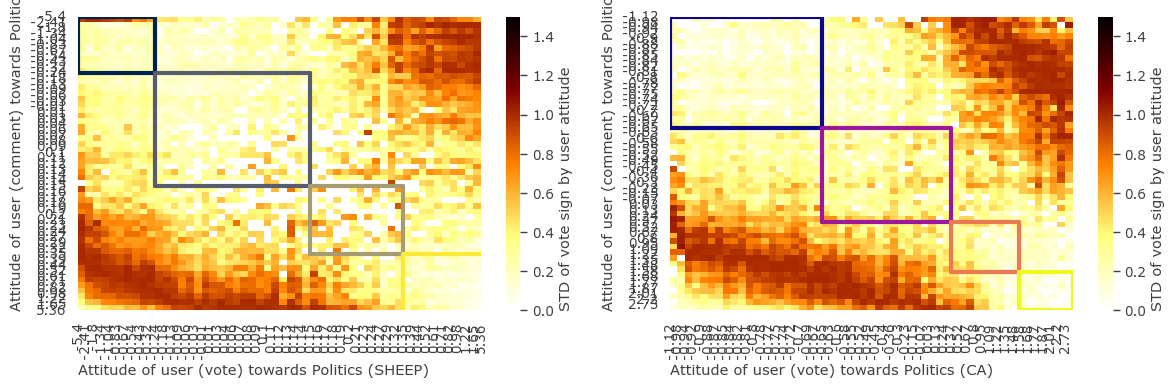

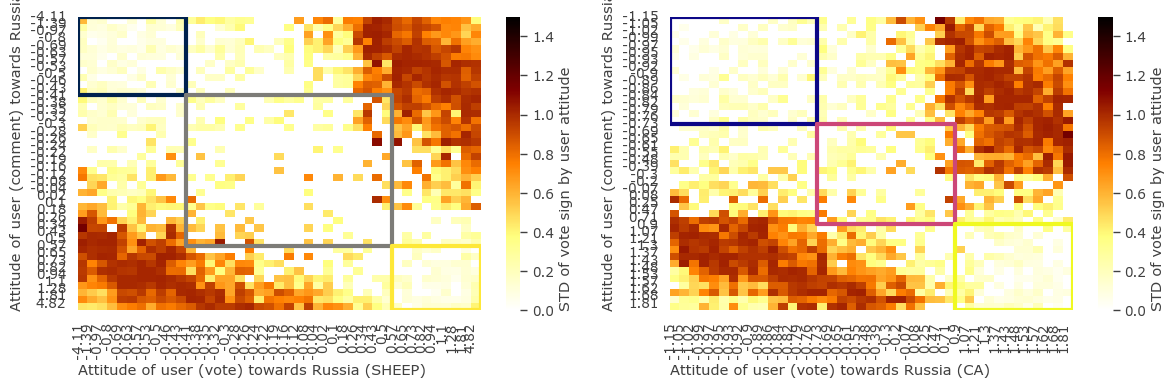

In [19]:
#Robustness test
for top in ["Politics", "Russia"]:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    As2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_sheep_comments, 
                    var="_pca_1d", flip=False, bins=None, type="sum_vote_std", label="SHEEP", squares=d_squares[f"{top}_sheep"])
    

    plt.subplot(1, 2, 2)
    Ac2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_ca_comments, 
                    var="_0", flip=False, bins=None, type="sum_vote_std", label="CA", squares=d_squares[f"{top}_ca"])
    
    plt.tight_layout()
    
    plt.show()


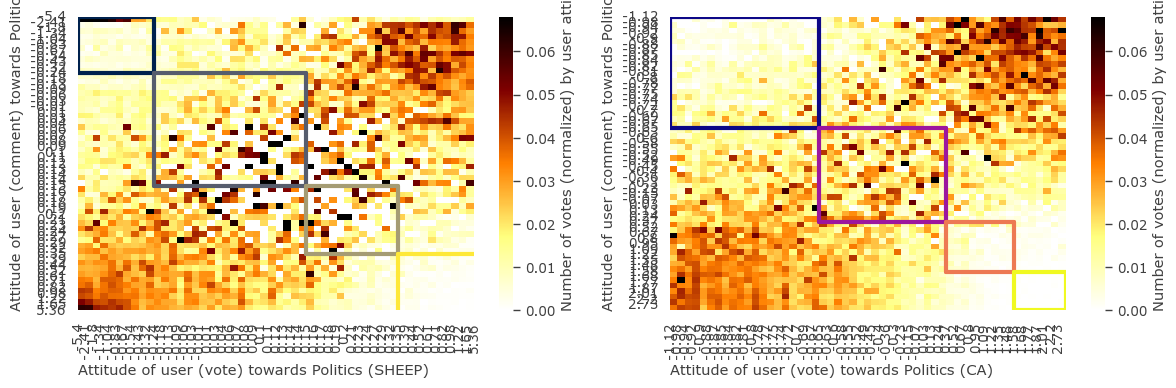

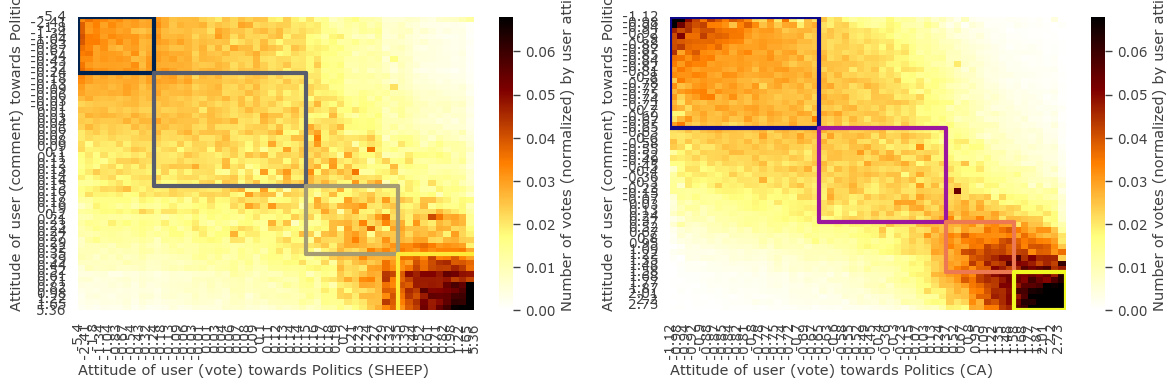

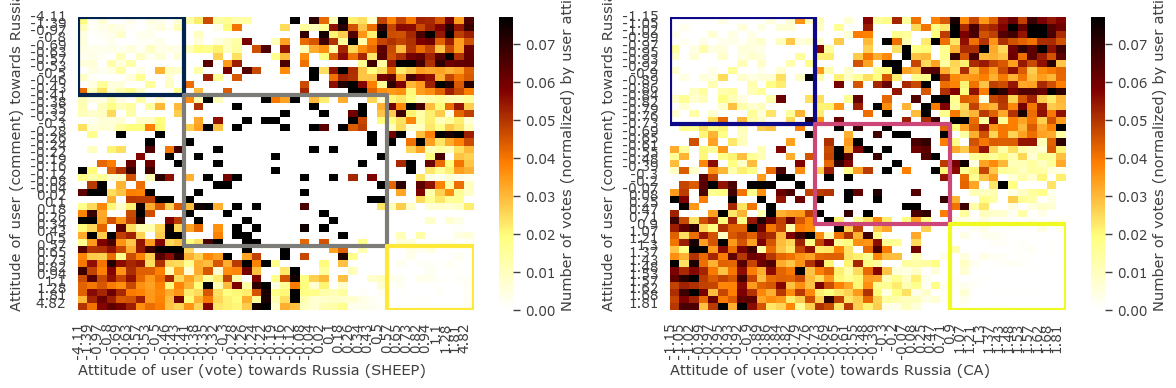

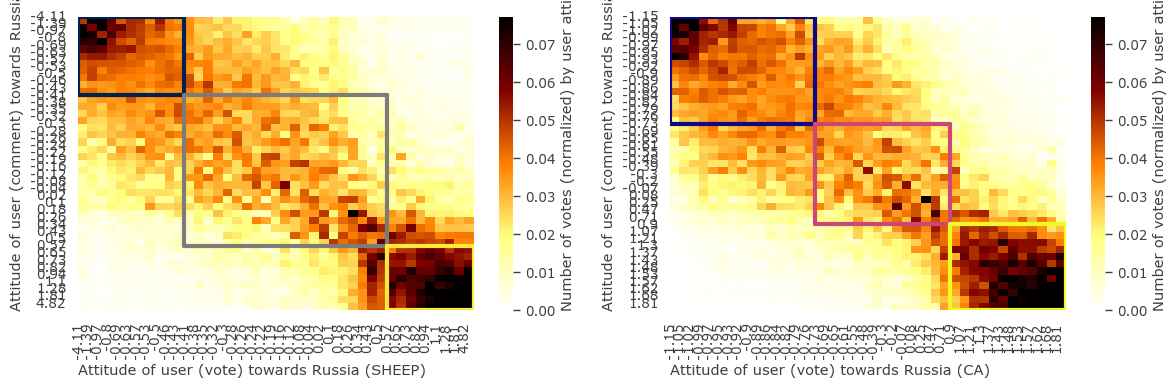

In [20]:
#Robustness test
for top in ["Politics", "Russia"]:
    for kind in ["len_neg", "len_pos"]:
        plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        As2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_sheep_comments, 
                        var="_pca_1d", flip=False, bins=None, type=kind, label="SHEEP", squares=d_squares[f"{top}_sheep"])
        

        plt.subplot(1, 2, 2)
        Ac2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_ca_comments, 
                        var="_0", flip=False, bins=None, type=kind, label="CA", squares=d_squares[f"{top}_ca"])
        
        plt.tight_layout()
        
        plt.show()


## Distributions


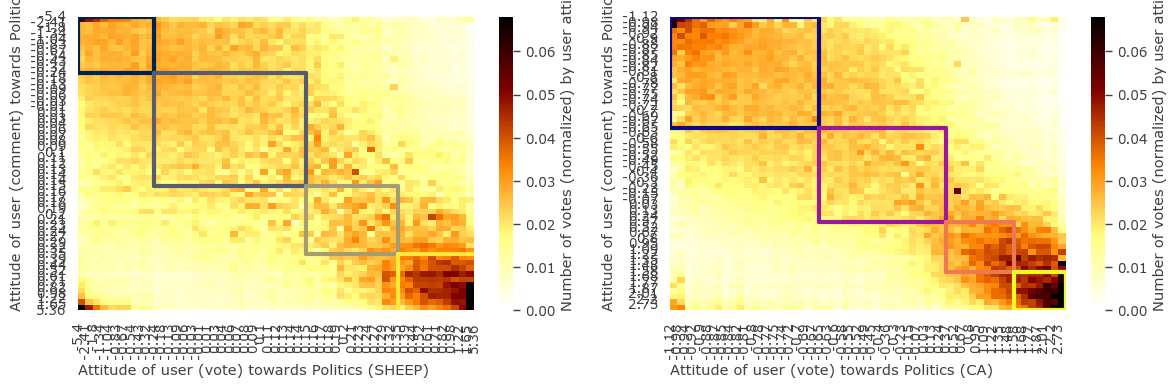

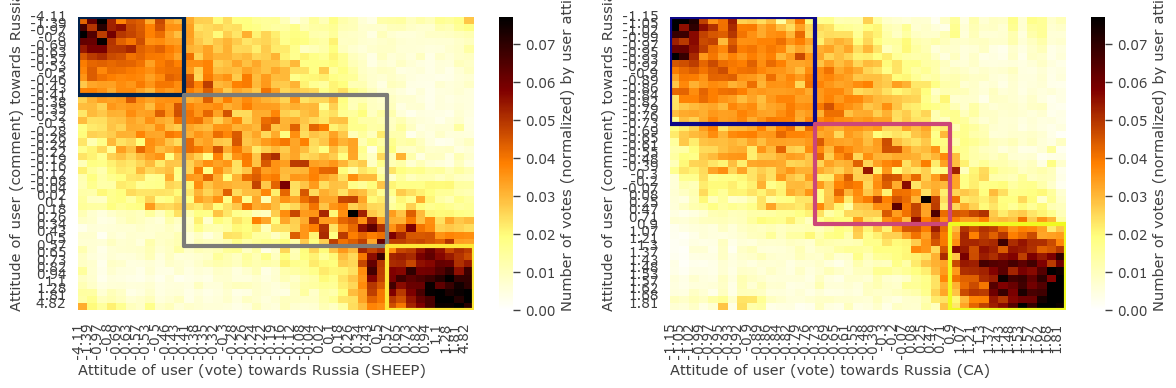

In [21]:
d_squares["Politics_sheep"]
#Robustness
for top in ["Politics", "Russia"]:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    As2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_sheep_comments, 
                    var="_pca_1d", flip=False, bins=None, type="len", label="SHEEP", squares=d_squares[f"{top}_sheep"])
    

    plt.subplot(1, 2, 2)
    Ac2 = s4.plot_vote_matrix(data_com, f"{top}", df_emb_ca_comments, 
                    var="_0", flip=False, bins=None, type="len", label="CA", squares=d_squares[f"{top}_ca"])
    
    plt.tight_layout()
    
    plt.show()


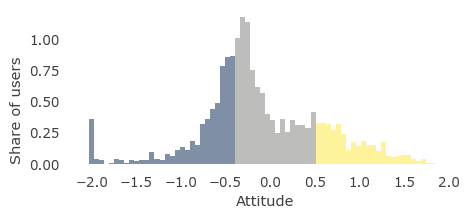

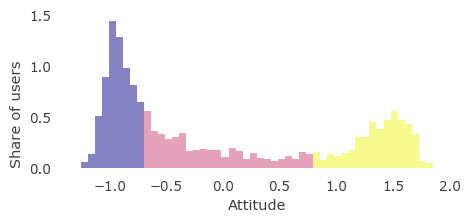

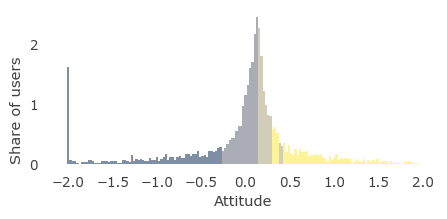

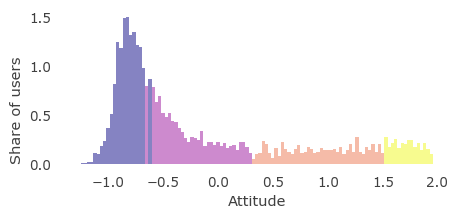

In [22]:
for topic in ["Russia", "Politics"]:
    plt.figure(figsize=(5, 2))
    s4.plot_hist(df_emb_sheep_comments[f"{topic}_pca_1d"].dropna(), d_partitions[f"{topic}_sheep"],
                d_squares[f"{topic}_sheep"], "SHEEP")
    plt.savefig(f"../figures/fig2_{topic}_hist_sheep.pdf", bbox_inches="tight")
    plt.figure(figsize=(5, 2))
    s4.plot_hist(df_emb_ca_comments[f"{topic}_0"].dropna(), d_partitions[f"{topic}_ca"],
                d_squares[f"{topic}_ca"], "CA")
    plt.savefig(f"../figures/fig2_{topic}_hist_ca.pdf", bbox_inches="tight")


### Some other plots not used in the paper

#### Heatmaps for individuals

In [23]:

def plot_vote_matrix_ind(data, topic, df_emb, users, var="_pca_1d", flip=False, bins=None):

    ideology = df_emb.set_index("story")[f"{topic}{var}"].dropna()
    if flip:
        ideology = -ideology
    ideology = ideology.to_dict()

    d = data.copy()
    d = d.loc[d["final_topic"]==topic]
    d = pd.concat([d, d.rename(columns={"username_vote": "username_post", "username_post": "username_vote" })])
    if bins is None:
        bins = np.sqrt(len(d["username_vote"].unique())) // 1.5 # 2
        if bins % 2 != 0:
            bins += 1

    d["u_p_id"] = d["username_post"].map(ideology)
    d["u_v_id"] = d["username_vote"].map(ideology)
    d = d.loc[d["username_vote"].isin(set(users))]
    print(len(d))
    d = d.dropna(subset=["u_v_id", "u_p_id"])
    i = ideology.values()
    # convert to numpy
    i = np.array(list(i))

    bins_perc = np.percentile(i, np.linspace(0, 100, int(bins)))
    #bins_perc = np.linspace(np.min(i), np.max(i), int(bins))

    bins_centers = np.round(1/2*(bins_perc[:-1]+bins_perc[1:]), 2)
    #d["u_v_id_cut"] = pd.cut(d["u_v_id"], bins_perc, duplicates='drop', labels=bins_centers, ordered=False)
    d["u_p_id_cut"] = pd.cut(d["u_p_id"], bins_perc, duplicates='drop', labels=bins_centers, ordered=False)

    plt.figure(figsize=(16, 4))
    plt.subplot(131)
    # Votes positive
    d_pos = d.loc[d["comment_vote"]==1]
    print(len(d_pos))
    d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
    d_pos = d_pos.loc[[_ for _ in users if _ in d_pos.index] ]
    d_pos = d_pos.fillna(0)
    d_pos[:] = np.log10(d_pos+1)
    if len(d_pos) > 0:
        sns.heatmap(d_pos,  cmap="afmhot_r", vmin=0, vmax=2)#, vmax=0.5/np.sqrt(len(bins_perc)))
    plt.yticks([])
    plt.title("Positive")
    plt.subplot(132)
    # Votes negative
    d_pos = d.loc[d["comment_vote"]==-1]
    d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
    d_pos = d_pos.fillna(0)
    d_pos = d_pos.loc[[_ for _ in users if _ in d_pos.index] ]
    d_pos[:] = np.log10(d_pos+1)
    print(len(d_pos))
    if len(d_pos) > 0:
        sns.heatmap(d_pos,  cmap="afmhot_r", vmin=0, vmax=2)#, vmax=0.5/np.sqrt(len(bins_perc)))
    plt.yticks([])
    plt.title("Negative")
    plt.subplot(133)

    # AVerage vote
    d = d.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(np.mean).unstack()
    d = d.fillna(0)

    d = d.loc[[_ for _ in users if _ in d.index] ]
    print(len(d_squares))
    if len(d) > 0:
        sns.heatmap(d,  cmap="RdBu", vmin=-1, vmax=1)
    plt.yticks([])
    plt.title("Vote")

15842
9768
40
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

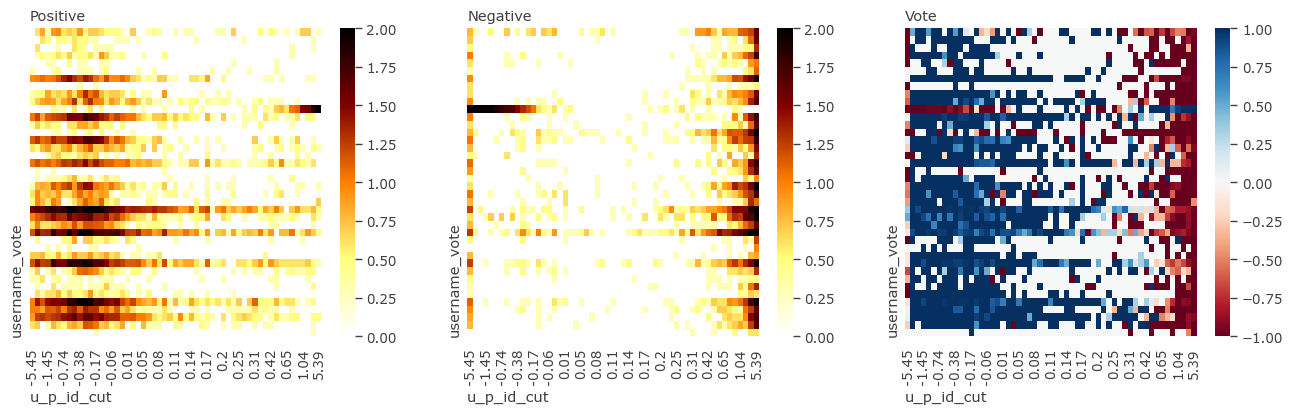

In [24]:
extr = df_emb_sheep_comments.sort_values(by="Politics_pca_1d").head(40)["story"]
plot_vote_matrix_ind(data_com, "Politics", df_emb_sheep_comments, extr, var="_pca_1d", flip=False, bins=None)

1928
1385
37
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

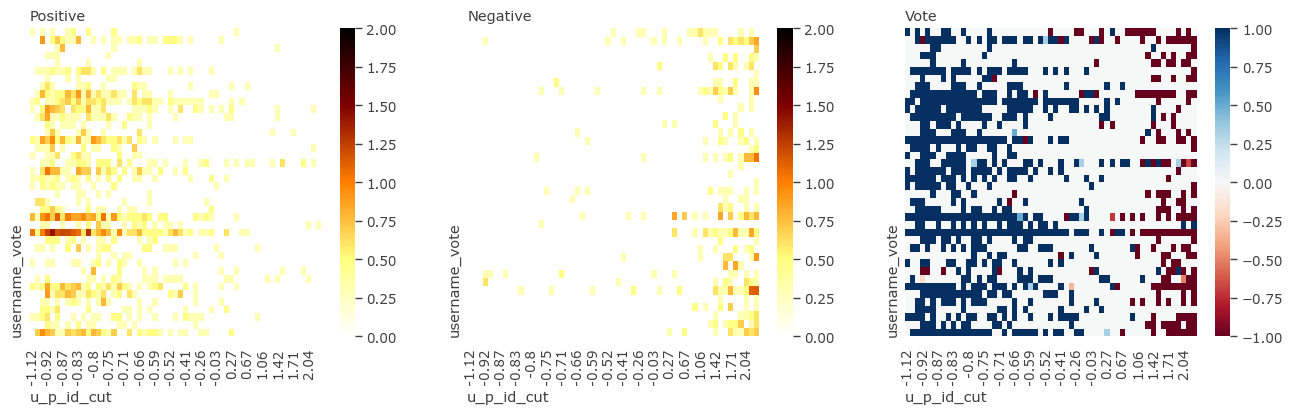

In [25]:
extr = df_emb_ca_comments.sort_values(by="Politics_0").head(40)["story"]
plot_vote_matrix_ind(data_com, "Politics", df_emb_ca_comments, extr, var="_0", flip=False, bins=None)

65945
48439
40
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

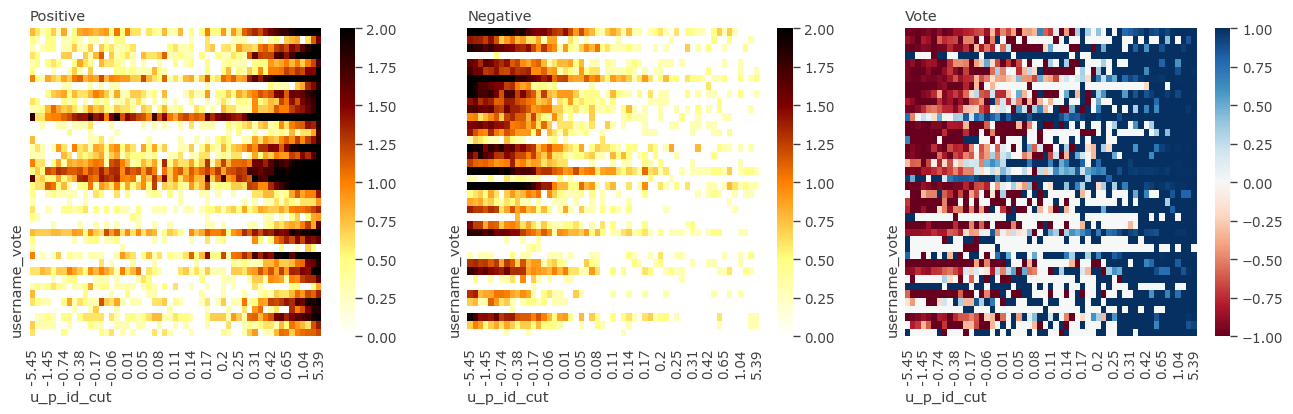

In [26]:
extr = df_emb_sheep_comments.sort_values(by="Politics_pca_1d", ascending=False).head(40)["story"]
plot_vote_matrix_ind(data_com, "Politics", df_emb_sheep_comments, extr, var="_pca_1d", flip=False, bins=None)

44470
33067
40
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

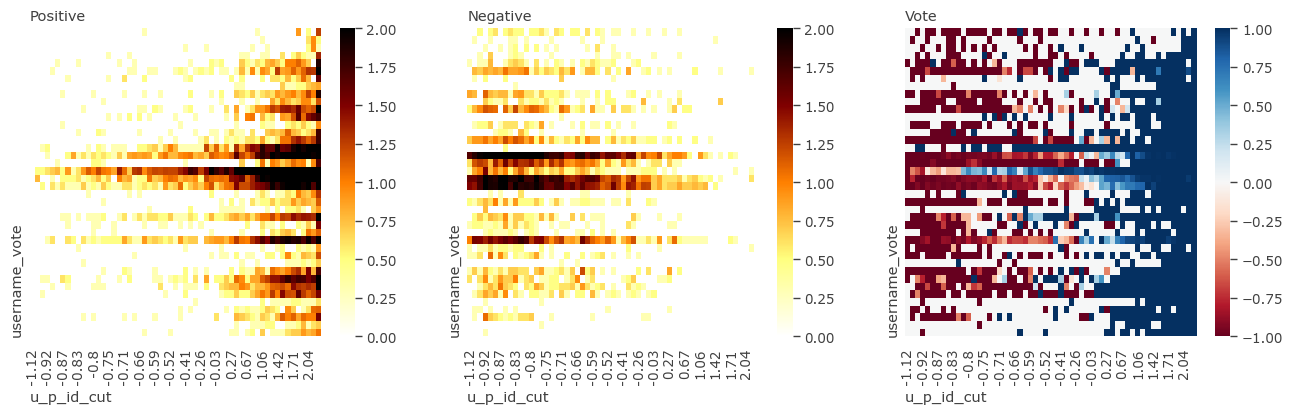

In [27]:
extr = df_emb_ca_comments.sort_values(by="Politics_0", ascending=False).head(40)["story"]
plot_vote_matrix_ind(data_com, "Politics", df_emb_ca_comments, extr, var="_0", flip=False, bins=None)

10772
8778
40
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

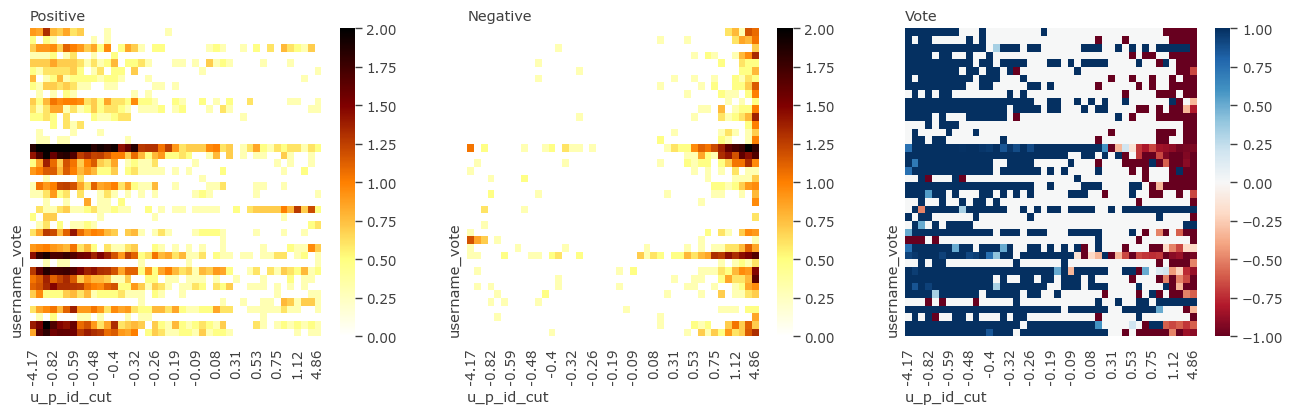

In [28]:
extr = df_emb_sheep_comments.sort_values(by="Russia_pca_1d").head(40)["story"]
plot_vote_matrix_ind(data_com, "Russia", df_emb_sheep_comments, extr, var="_pca_1d", flip=False, bins=None)

16262
14358
35
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

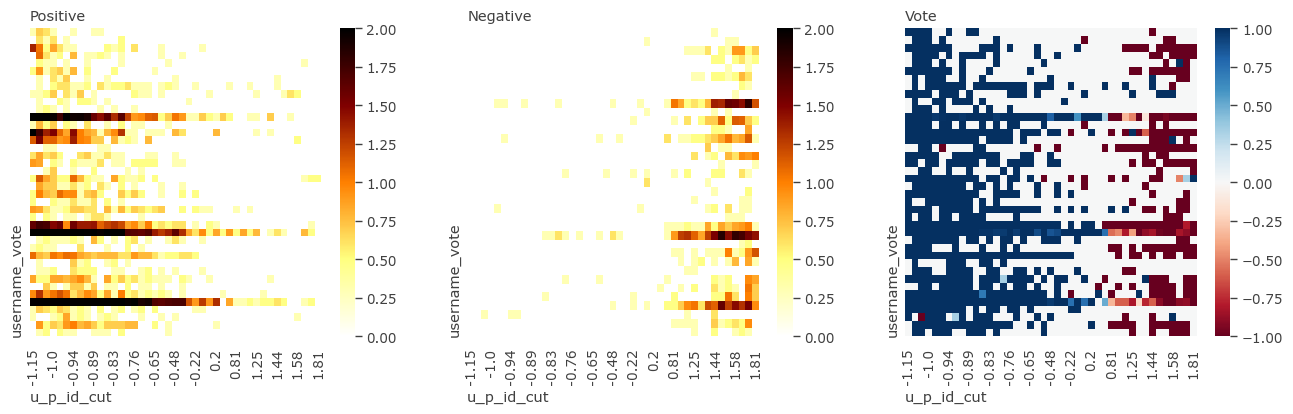

In [29]:
extr = df_emb_ca_comments.sort_values(by="Russia_0").head(40)["story"]
plot_vote_matrix_ind(data_com, "Russia", df_emb_ca_comments, extr, var="_0", flip=False, bins=None)

24816
19629
40
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

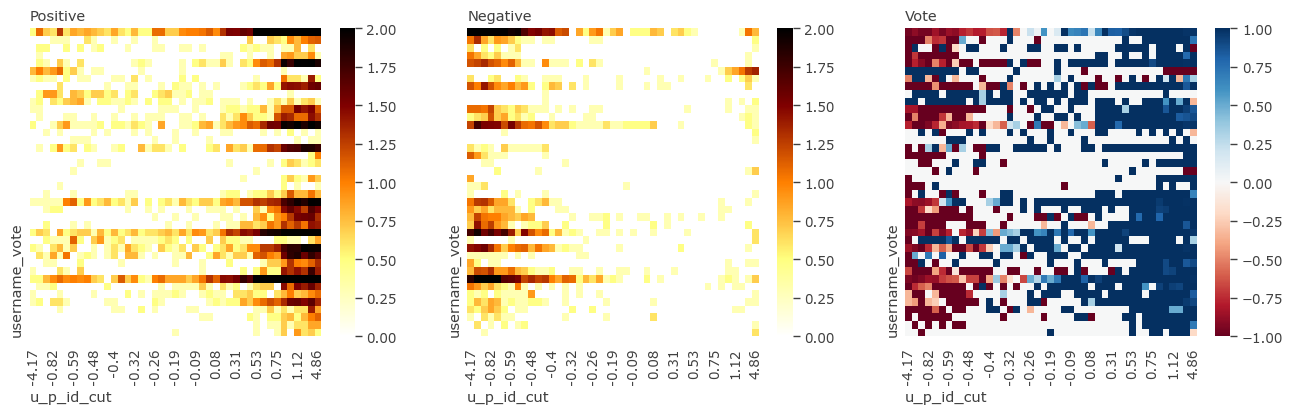

In [30]:
extr = df_emb_sheep_comments.sort_values(by="Russia_pca_1d", ascending=False).head(40)["story"]
plot_vote_matrix_ind(data_com, "Russia", df_emb_sheep_comments, extr, var="_pca_1d", flip=False, bins=None)

12421
10254
34
4


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d_pos = d_pos.groupby(["username_vote", "u_p_id_cut"])["comment_vote"].agg(len).unstack()
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_28224/2318643860.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

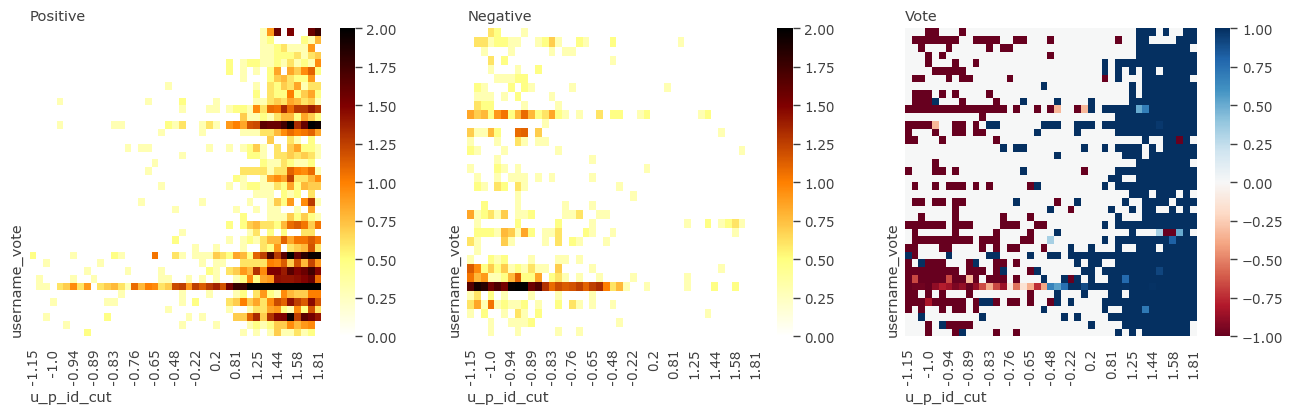

In [31]:
extr = df_emb_ca_comments.sort_values(by="Russia_0", ascending=False).head(40)["story"]
plot_vote_matrix_ind(data_com, "Russia", df_emb_ca_comments, extr, var="_0", flip=False, bins=None)

### Validation of attitude/ideology scale

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


general from twitter


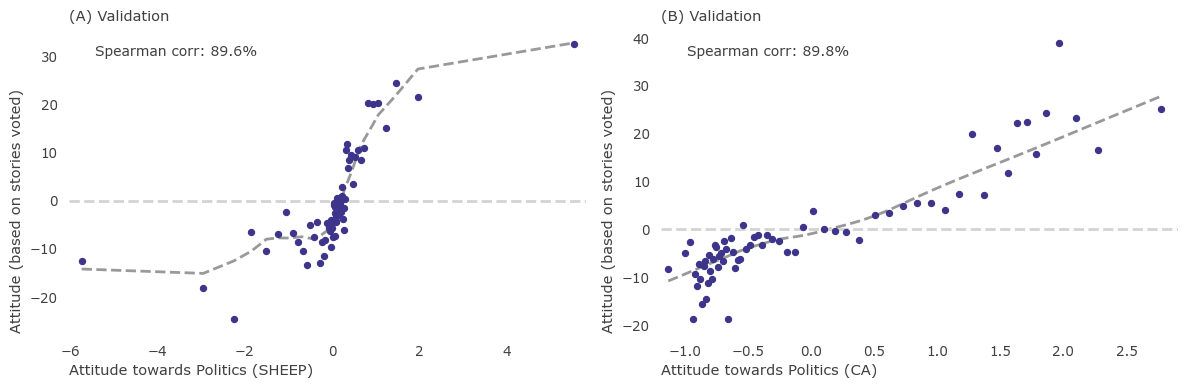

{'vozpopuli': 1.8038067085391543, 'elsaltodiario': -1.6223199671945572, 'theobjective': 2.6274263171412557, 'ctxt': -1.7675918718601393, 'diario16': -1.6780849493176713, 'lavozdelsur': -1.7186419992960662, 'elconfidencialdigital': 1.4738354897574795, 'libertaddigital': 1.8150072298534483}
{'infobae': -0.6909998581646234, 'diario-octubre': 2.535667309458046, 'revistaejercitos': -1.482161261041246, 'rt': 3.7865290639600717, 'actualidad-rt': 1.5311507419190038}
general from ours


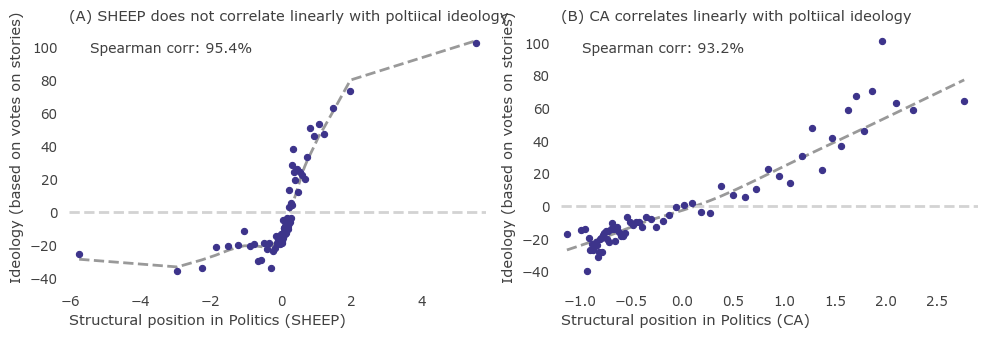

general from extreme


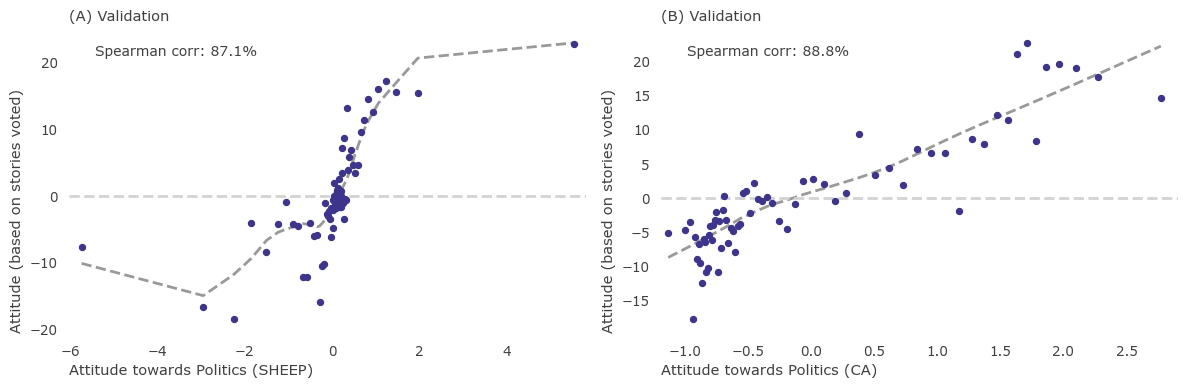

general from outs


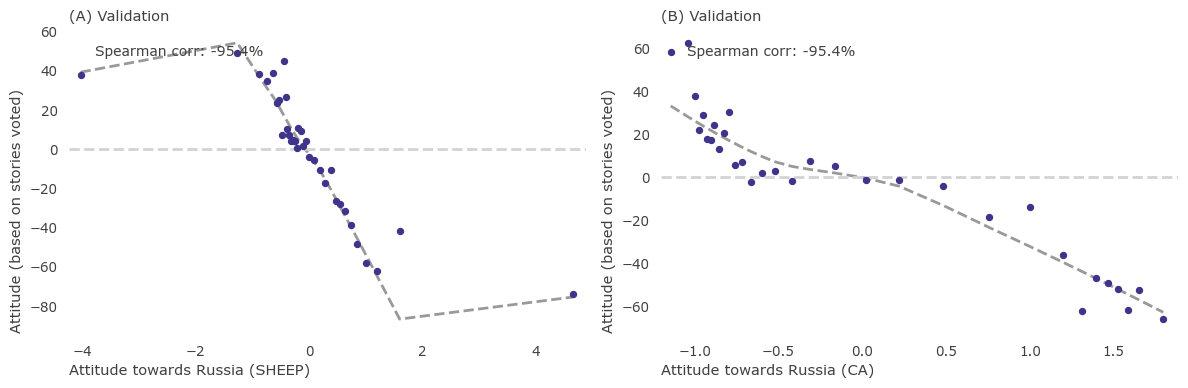

general from extreme


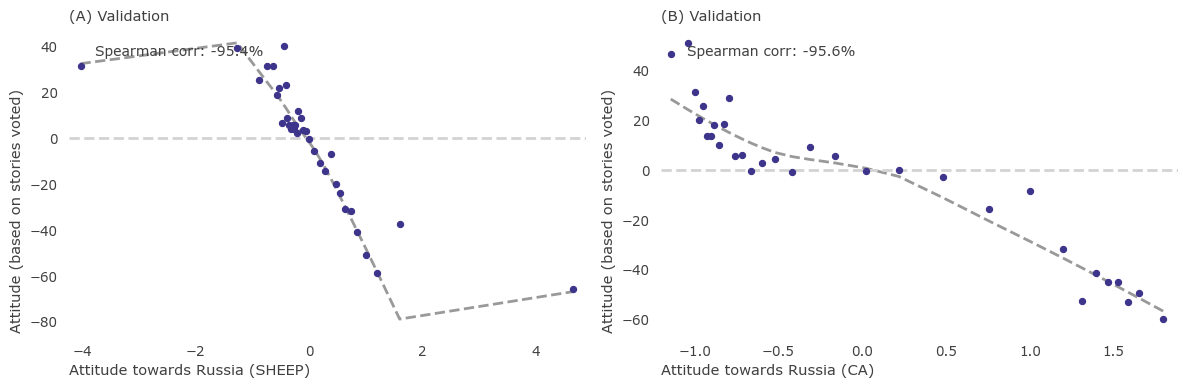

general from RT
{'rt': 3.7865290639600717, 'actualidad-rt': 1.5311507419190038}


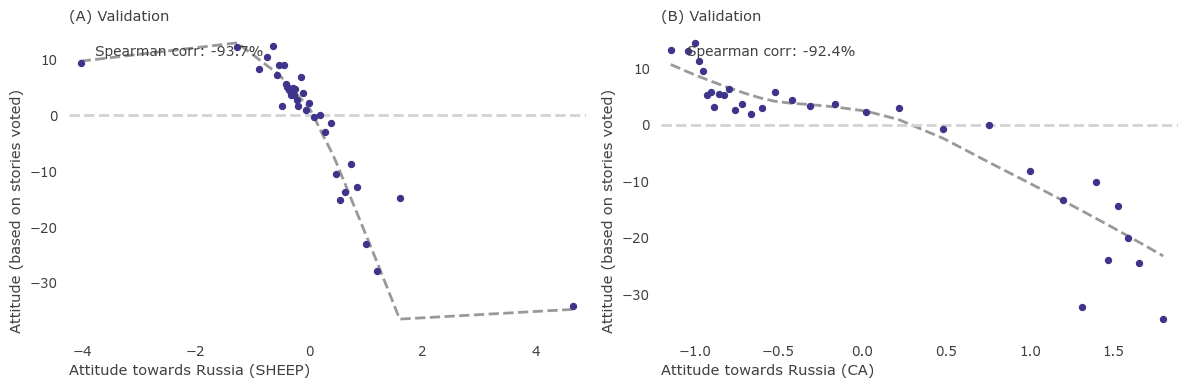

In [33]:
correct_votes = True
adjust_limit = 0
bin_size = 50

print("general from twitter")
for top in ["Politics"]:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    s4.plot_range(df_emb_sheep_comments, f"{top}_pca_1d", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=mn.domain_ideology_twitter)
    plt.title("(A) Validation")
    plt.xlabel(f"Attitude towards {top} (SHEEP)")
    plt.subplot(1, 2, 2)
    s4.plot_range(df_emb_ca_comments, f"{top}_0", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=mn.domain_ideology_twitter)
    plt.title("(B) Validation")
    plt.xlabel(f"Attitude towards {top} (CA)")
    plt.tight_layout()
    plt.show()


id_pol = df_emb_sheep_outlets.set_index("story")["Politics_pca_1d"].dropna().to_dict()
pol_perc = np.percentile(list(id_pol.values()), [7.5,92.5])
id_pol_extreme = {k: v for k, v in id_pol.items() if (v < pol_perc[0]) or (v > pol_perc[1])}
del id_pol_extreme["lavozdegalicia"]
del id_pol_extreme["publico"]
print(id_pol_extreme)

id_rus = df_emb_sheep_outlets.set_index("story")["Russia_pca_1d"].dropna().to_dict()
rus_perc = np.percentile(list(id_rus.values()), [7.5,92.5])
id_rus_extreme = {k: v for k, v in id_rus.items() if (v < rus_perc[0]) or (v > rus_perc[1])}
del id_rus_extreme["bbc"]

print(id_rus_extreme)

print("general from ours")
for top in ["Politics"]:
    plt.figure(figsize=(10, 3.5))
    plt.subplot(1, 2, 1)
    s4.plot_range(df_emb_sheep_comments, f"{top}_pca_1d", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_pol)
    plt.title("(A) SHEEP does not correlate linearly with poltiical ideology")
    plt.xlabel(f"Structural position in {top} (SHEEP)")
    plt.ylabel("Ideology (based on votes on stories)")
    plt.subplot(1, 2, 2)
    s4.plot_range(df_emb_ca_comments, f"{top}_0", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_pol)
    plt.title("(B) CA correlates linearly with poltiical ideology")
    plt.ylabel("Ideology (based on votes on stories)")
    plt.xlabel(f"Structural position in {top} (CA)")
    plt.tight_layout()
    plt.savefig(f"../figures/fig4_{top}_validation_ideology.pdf", bbox_inches="tight")
    plt.savefig(path_figures + f"fig4_{top}_validation_ideology.pdf", bbox_inches="tight")
    plt.show()


print("general from extreme")
for top in ["Politics"]:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    s4.plot_range(df_emb_sheep_comments, f"{top}_pca_1d", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_pol_extreme)
    plt.title("(A) Validation")
    plt.xlabel(f"Attitude towards {top} (SHEEP)")
    plt.subplot(1, 2, 2)
    s4.plot_range(df_emb_ca_comments, f"{top}_0", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_pol_extreme)
    plt.title("(B) Validation")
    plt.xlabel(f"Attitude towards {top} (CA)")
    plt.tight_layout()
    plt.show()


print("general from outs")
for top in ["Russia"]:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    s4.plot_range(df_emb_sheep_comments, f"{top}_pca_1d", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_rus)
    plt.title("(A) Validation")
    plt.xlabel(f"Attitude towards {top} (SHEEP)")
    plt.subplot(1, 2, 2)
    s4.plot_range(df_emb_ca_comments, f"{top}_0", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_rus)
    plt.title("(B) Validation")
    plt.xlabel(f"Attitude towards {top} (CA)")
    plt.tight_layout()
    plt.show()

print("general from extreme")
for top in ["Russia"]:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    s4.plot_range(df_emb_sheep_comments, f"{top}_pca_1d", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_rus_extreme)
    plt.title("(A) Validation")
    plt.xlabel(f"Attitude towards {top} (SHEEP)")
    plt.subplot(1, 2, 2)
    s4.plot_range(df_emb_ca_comments, f"{top}_0", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_rus_extreme)
    plt.title("(B) Validation")
    plt.xlabel(f"Attitude towards {top} (CA)")
    plt.tight_layout()
    plt.show()

print("general from RT")
id_rus = df_emb_sheep_outlets.set_index("story")["Russia_pca_1d"].dropna().to_dict()
rus_perc = np.percentile(list(id_rus.values()), [7.5,92.5])
id_rus_extreme = {k: v for k, v in id_rus.items() if k in ["rt", "actualidad-rt"]}
print(id_rus_extreme)
for top in ["Russia"]:
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    s4.plot_range(df_emb_sheep_comments, f"{top}_pca_1d", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_rus_extreme)
    plt.title("(A) Validation")
    plt.xlabel(f"Attitude towards {top} (SHEEP)")
    plt.subplot(1, 2, 2)
    s4.plot_range(df_emb_ca_comments, f"{top}_0", data_st, domains=domains, adjust_limit=0, bin_size=bin_size, correct_votes=correct_votes, id=id_rus_extreme)
    plt.title("(B) Validation")
    plt.xlabel(f"Attitude towards {top} (CA)")
    plt.tight_layout()
    plt.show()



In [34]:
for topic in ["Russia", "Politics"]:
    votes = data_com.loc[data_com["final_topic"]==topic].groupby(["username_vote", "username_post"]).agg({"comment_vote": ["count", "mean"]}).reset_index()
    votes.columns = ["user1", "user2", "n_comments", "mean"]
 
    votes = pd.merge(votes, votes.rename(columns={"user1": "user2", "user2": "user1"}), on=["user1", "user2"], how="outer", suffixes=("", "_y"))
    #votes = votes.loc[(votes["n_comments"] + votes["n_comments_y"])>10]
    votes = votes.loc[votes["n_comments"] > 2]
    votes = votes.loc[votes["n_comments_y"] > 2]
    votes["mean_1"] = pd.cut(votes["mean"], bins=[-1.01,-0.899,-0.3,0.3,0.899,1.01])#, labels=[-1, -0.5, 0, 0.5, 1])
    votes["mean_2"] = pd.cut(votes["mean_y"], bins=[-1.01,-0.899,-0.3,0.3,0.899,1.01])#, labels=[-1, -0.5, 0, 0.5, 1])
    a = pd.crosstab(votes["mean_1"], votes["mean_2"])#, normalize=1)
    a.to_csv(f"{path_figures}/crosstab_{topic}.csv")
    display(a)

mean_2           (-1.01, -0.899]  (-0.899, -0.3]  (-0.3, 0.3]  (0.3, 0.899]  \
mean_1                                                                        
(-1.01, -0.899]              116               2            2             1   
(-0.899, -0.3]                 2               2            1             0   
(-0.3, 0.3]                    2               1            0             1   
(0.3, 0.899]                   1               0            1             0   
(0.899, 1.01]                  0               1            1            17   

mean_2           (0.899, 1.01]  
mean_1                          
(-1.01, -0.899]              0  
(-0.899, -0.3]               1  
(-0.3, 0.3]                  1  
(0.3, 0.899]                17  
(0.899, 1.01]             2892

mean_2           (-1.01, -0.899]  (-0.899, -0.3]  (-0.3, 0.3]  (0.3, 0.899]  \
mean_1                                                                        
(-1.01, -0.899]               96              15            6             4   
(-0.899, -0.3]                15               8            4             5   
(-0.3, 0.3]                    6               4            0             5   
(0.3, 0.899]                   4               5            5            24   
(0.899, 1.01]                  3               6            5            96   

mean_2           (0.899, 1.01]  
mean_1                          
(-1.01, -0.899]              3  
(-0.899, -0.3]               6  
(-0.3, 0.3]                  5  
(0.3, 0.899]                96  
(0.899, 1.01]             5060